# JIGSAW Toxic Comment Classification Challenge

## Description

Ce dataset recense un grand nombre de commentaires anglais Wikipedia labellisés par des humains en fonction de leur toxicité.

## Accéder au dataset

Le dataset provient d'une compétition Kaggle et peut être obtenu à partir du lien suivant : [dataset](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)

## Type de toxicité
-  toxic
-  severe_toxic
-  obscene
-  threat
-  insult
-  identity_hate

## Usage
Cet ensemble de données est particulièrement utile aux chercheurs et développeurs travaillant sur des solutions de modération automatique de contenu et de détection de comportements toxiques en ligne. Il peut être utilisé pour entraîner des modèles d'apprentissage automatique afin d'identifier et de filtrer les commentaires nuisibles dans les communautés en ligne.

In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from constants import CATEGORIES
from utils.preprocessing import load_dataframes

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [3]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [2]:
(df_train, df_val , df_test) = load_dataframes()

In [5]:
df_train.describe()

toxic  severe_toxic        obscene         threat  \
count  127656.000000  127656.00000  127656.000000  127656.000000   
mean        0.095867       0.00998       0.052751       0.003165   
std         0.294410       0.09940       0.223537       0.056167   
min         0.000000       0.00000       0.000000       0.000000   
25%         0.000000       0.00000       0.000000       0.000000   
50%         0.000000       0.00000       0.000000       0.000000   
75%         0.000000       0.00000       0.000000       0.000000   
max         1.000000       1.00000       1.000000       1.000000   

              insult  identity_hate  overall_toxic  
count  127656.000000  127656.000000  127656.000000  
mean        0.049062       0.008703       0.101687  
std         0.215997       0.092884       0.302238  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000

In [6]:
f"{len(df_train)=}", f"{len(df_val)=}", f"{len(df_test)=}"

('len(df_train)=127656', 'len(df_val)=31915', 'len(df_test)=63978')

In [7]:
toxic = df_train[df_train['overall_toxic'] == 1].shape[0]
non_toxic = df_train[df_train['overall_toxic'] == 0].shape[0]

px.pie(names=['globalement toxique', 'globalement non-toxique'], values=[toxic, non_toxic], title='Répartition de la toxicité des commentaires')

In [8]:
category_counts = df_train[CATEGORIES].sum().reset_index()
category_counts.columns = ['Catégorie', 'count']
category_counts["Pourcentage"] =( category_counts["count"] / len(df_train[df_train["overall_toxic"] == 1]))*100
category_counts["pourcentage_text"] = category_counts["Pourcentage"].round(1).astype(str) + '%'
px.bar(category_counts, x='Catégorie', y='Pourcentage', text='pourcentage_text', title='Distribution des catégories sur les commentaires globalement toxiques')

## Répartition des données

### Nombre de commentaires
-  Train : 127 656 commentaires
-  Validation : 31 915 commentaires
-  Test: 63 978 commentaires

### Répartition des labels sur tous les commentaires du dataset d'entraînement
- toxic : 9.6%
- severe_toxic : 1.0%
- obscene : 5.3%
- threat : 0.3%
- insult : 4.9%
- identity-hate : 0.9% 
- overall-toxic : 10.2%
- overall-non-toxic : 89.8%

### Répartition des labels sur les commentaires globalement toxiques
- toxic : 94.3%
- severe_toxic : 9.8%
- obscene : 51.9%
- threat : 3.1%
- insult : 48.2%
- identity-hate : 8.6% 

Tout d'abord on peut remarqué que la somme des pourcentages n'est pas égales à 100% car un commentaire peut avoir plusieurs labels. On est donc dans un problème de classification multi-labels.

On peut constater que les commentaires toxiques sont minoritaires dans l'ensemble des données. Il y a aussi une répartition inégale au sein des labels de toxicité. Cela peut poser des problèmes lors de l'entraînement des modèles, car les classes minoritaires peuvent être sous-représentées et donc mal apprises.

## Correlation

<Axes: >

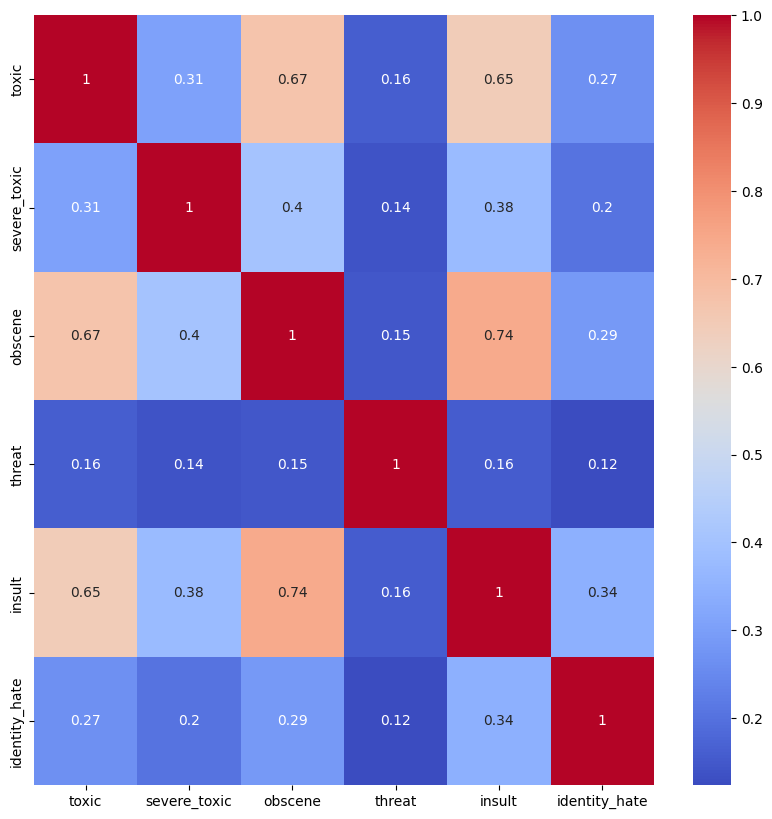

In [9]:
corr = df_train[CATEGORIES].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

On peut remarqué que les labels de toxicité sont fortement corrélés entre eux. On peut dès à présent anticiper une difficulté du modèle à distinge un commentaire toxique d'un commentaire obscene (74% de corrélation). Cela représente un point à prendre en compte lors de la conception du modèle.

### Distribution de la longueur des commentaires


In [10]:
df_train['comment_length'] = df_train['comment_text'].apply(len)
x_label = 'Longeur des Commentaires'
df_train_fr = df_train.rename(columns={"comment_length": x_label})

fig = px.histogram(df_train_fr, x= x_label, histnorm="probability", width=760)
fig.update_layout(yaxis_title_text = 'Probabilité')
fig.show()

In [11]:
df_train['comment_length'].describe()

count    127656.000000
mean        395.248277
std         593.430372
min           6.000000
25%          96.000000
50%         205.000000
75%         436.000000
max        5000.000000
Name: comment_length, dtype: float64


La distribution de la longueur des commentaires est très variée. La longueur moyenne des commentaires est de 395 caractères, avec un écart-type de 593 caractères. La longueur maximale d'un commentaire est de 5000 caractères. Cela peut poser des problèmes lors de la conception du modèle, car les modèles de traitement automatique du langage naturel (NLP) peuvent avoir des difficultés à traiter des commentaires de longueur variable. Il est donc important de prétraiter les données pour normaliser la longueur des commentaires.

## Distribution des mots

In [12]:
import re
sents = list(df_train["comment_text"])
sents_joined = "".join(sents)
words_list = re.findall(r'\w+', sents_joined.lower())
words_set = set(words_list)

In [13]:
"Nombre de mot uniques", len(words_set)

('Nombre de mot uniques', 179743)

### Mot les plus fréquents

In [14]:
from collections import Counter
Counter(words_list).most_common(50)

[('the', 398617),
 ('to', 238805),
 ('i', 191465),
 ('and', 180009),
 ('of', 179953),
 ('you', 173641),
 ('a', 172585),
 ('is', 141281),
 ('that', 128638),
 ('it', 118827),
 ('in', 116843),
 ('for', 82301),
 ('this', 78091),
 ('not', 75107),
 ('on', 72243),
 ('be', 66742),
 ('as', 62146),
 ('s', 58092),
 ('have', 57900),
 ('are', 57619),
 ('your', 50353),
 ('t', 48884),
 ('with', 47956),
 ('if', 46986),
 ('article', 46244),
 ('was', 43591),
 ('or', 42893),
 ('but', 40863),
 ('wikipedia', 38832),
 ('page', 36947),
 ('my', 36639),
 ('an', 36405),
 ('from', 33379),
 ('by', 33156),
 ('do', 31932),
 ('at', 31741),
 ('can', 31537),
 ('me', 29938),
 ('about', 29781),
 ('so', 29304),
 ('talk', 29169),
 ('what', 28347),
 ('there', 28274),
 ('all', 25350),
 ('has', 24733),
 ('will', 24600),
 ('please', 23586),
 ('would', 23533),
 ('one', 23505),
 ('they', 23381)]

### WordCloud
On peut visualiser les mots les plus fréquents dans les commentaires en utilisant un WordCloud. Cela peut donner une idée des mots les plus fréquemment utilisés dans les commentaires toxiques.

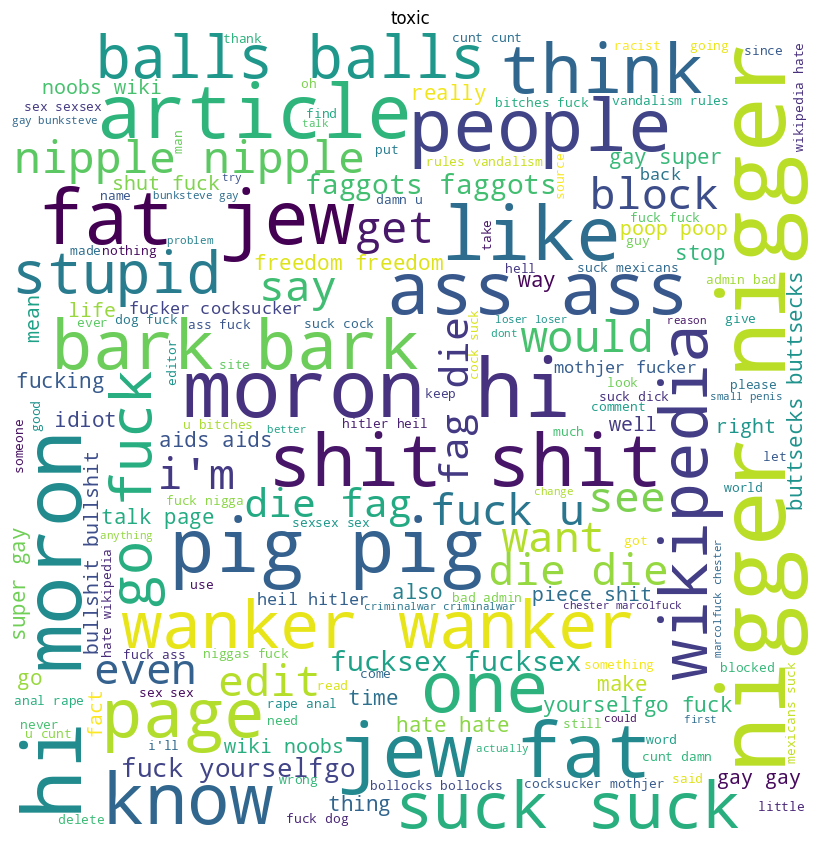

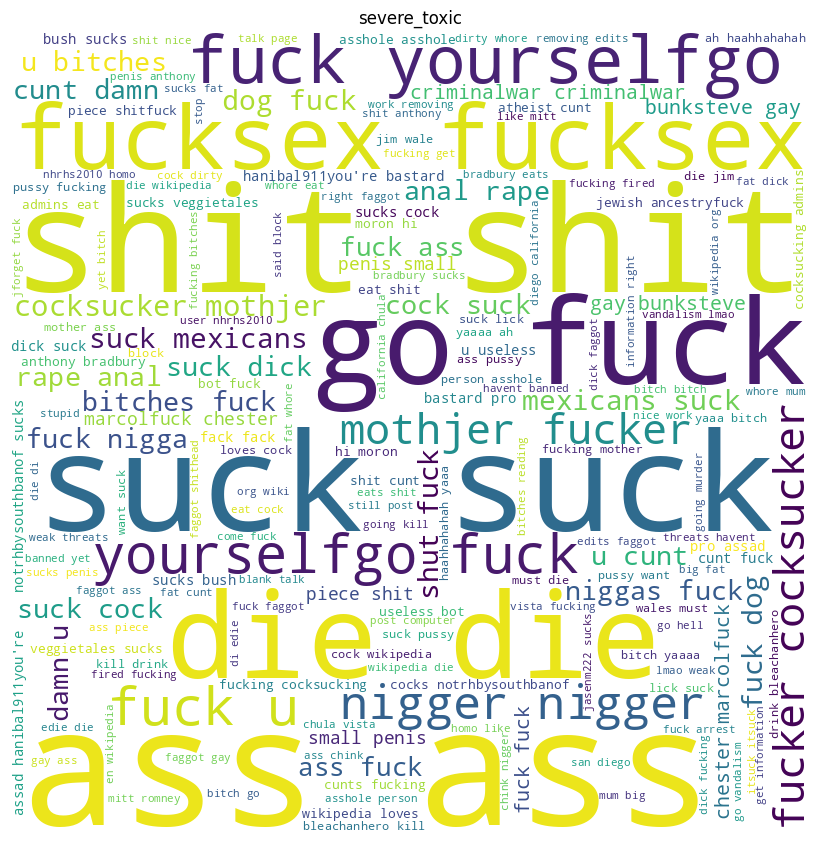

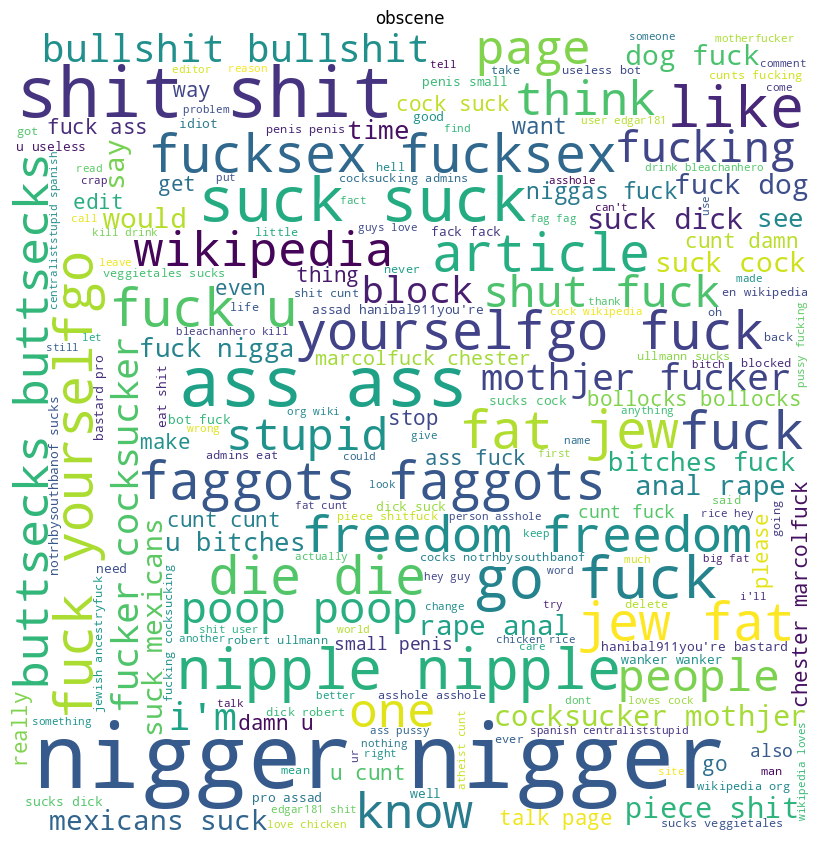

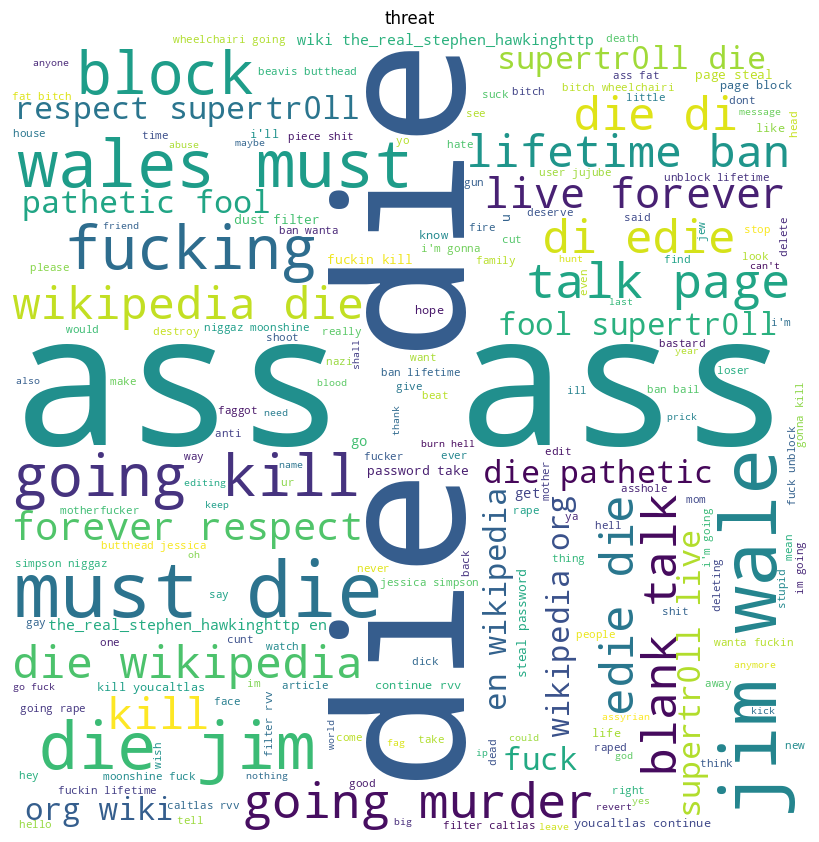

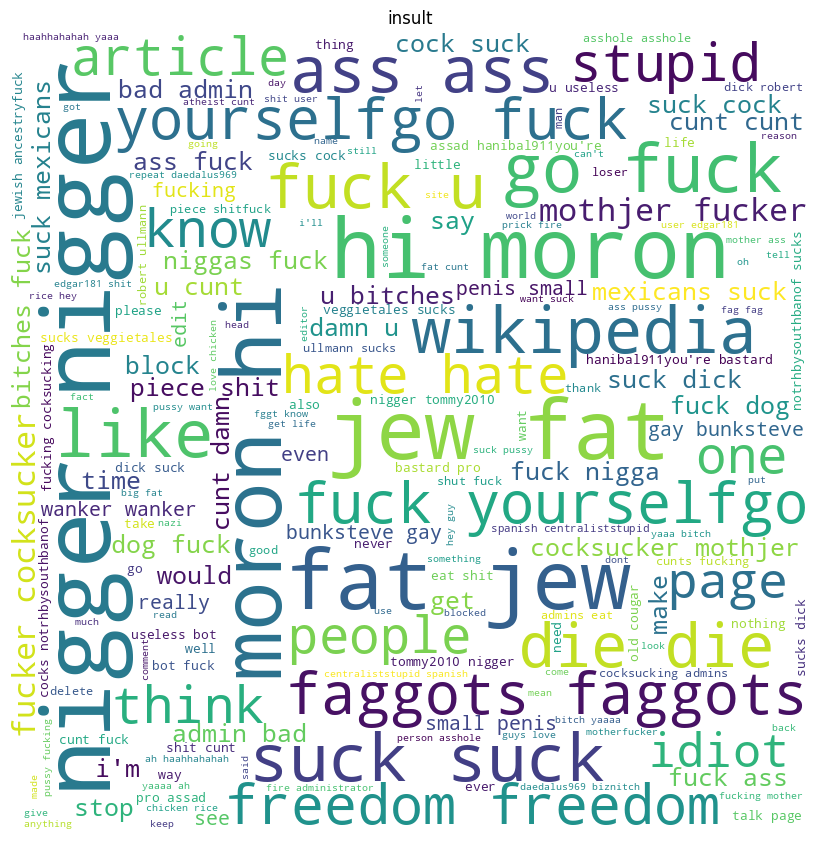

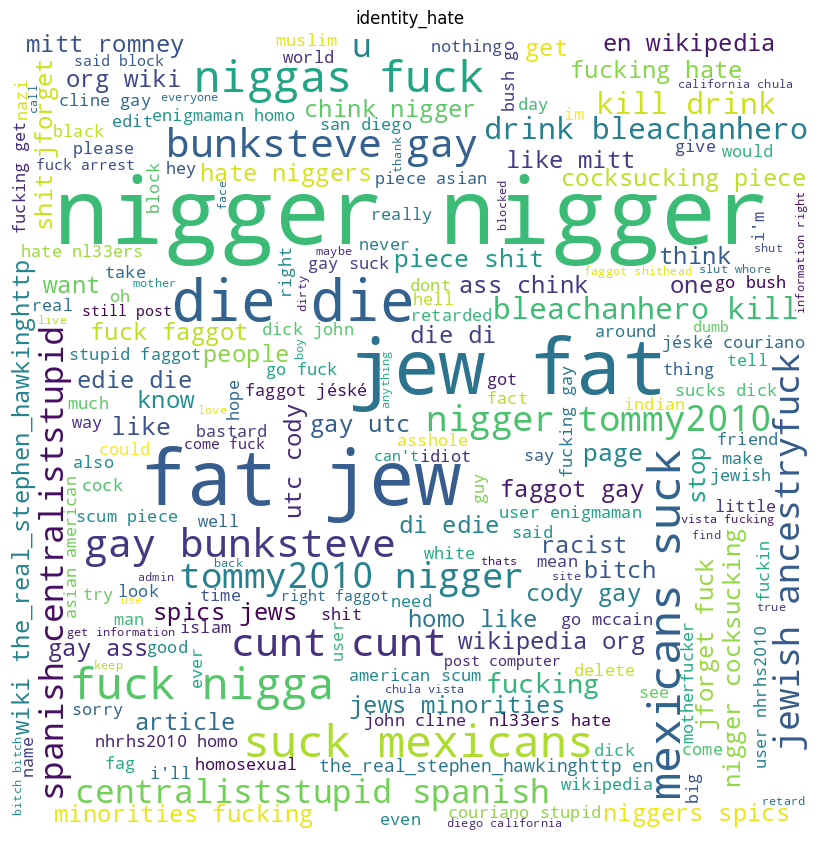

In [15]:
for category in CATEGORIES:
    stopwords_set = set(stopwords.words('english'))
    toxic_comments = df_train[df_train[category] == 1]['comment_text']
    toxic_comments = toxic_comments.str.cat(sep=' ')
    toxic_comments = toxic_comments.lower()
    toxic_comments = toxic_comments.split()
    toxic_comments = [word for word in toxic_comments if word not in stopwords_set]
    toxic_comments = ' '.join(toxic_comments)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_set, 
                min_font_size = 10).generate(toxic_comments)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(category)
    plt.show()